### 의사결정 트리 학습법의 기본 알고리즘

- 참고 사이트 : https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html  https://lovit.github.io/machine%20learning/2018/04/30/get_rules_from_trained_decision_tree/

- 연습문제 코드 : https://github.com/Hatchin/Machine-Learning-Zhou_Zhihua/blob/master/DecisionTree/CART/4.4.ipynb

sklearn은 CART를 사용함. 범주형 변수는 지원 X.

In [1]:
import pandas as pd
import numpy as np
from sklearn import tree
import pydotplus 
from pprint import pprint
from sklearn.externals.six import StringIO
from IPython.core.display import Image
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

water_melon_data_2 = 표 4.1 (수박 데이터 세트 2.0)

In [2]:
water_melon_data_2 = pd.read_pickle('water_melon_data_2')

In [3]:
water_melon_data_2.head()

,번호,색깔,꼭지모양,소리,줄무늬,배꼽 모양,감촉,잘 익은 수박
0,1,청록색,말림,혼탁,선명함,움푹 패임,단단함,예
1,2,진녹색,말림,둔탁,선명함,움푹 패임,단단함,예
2,3,진녹색,말림,혼탁,선명함,움푹 패임,단단함,예
3,4,청록색,말림,둔탁,선명함,움푹 패임,단단함,예
4,5,연녹색,말림,혼탁,선명함,움푹 패임,단단함,예


In [4]:
water_melon_data_2.columns = ['num','color','tap_shape','sound','stripe','navel_shape','texture','ripe']

#### 정보 엔트로피(information entropy) : 샘플 집합의 순도를 측정하는데 자주 사용되는 지표

In [5]:
def infoEntropy(column_name):
    elements, counts = np.unique(column_name, return_counts = True)
    info_entropy = -np.sum([(counts[i]/np.sum(counts)) * np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    return info_entropy

In [6]:
print('Ent = ', round(infoEntropy(water_melon_data_2['color']), 5))

Ent =  1.57986


#### 정보이득(information gain) 
: 분할전 Entropy와 분할 후 Entropy의 차이 (상위 노드의 엔트로피에서 하위 노드의 엔트로피를 뺀 값)

In [7]:
def infoGain(data,column_name, target_column):
    # 전체 엔트로피 계산
    total_entropy = infoEntropy(data[target_column])
    
    # 가중 엔트로피 계산
    vals,counts= np.unique(data[column_name],return_counts=True)
    Weighted_Entropy = np.sum([(counts[i]/np.sum(counts))*
                               infoEntropy(data.where(data[column_name]==vals[i]).dropna()[target_column])
                               for i in range(len(vals))])
    
    # 정보이득 계산
    Information_Gain = total_entropy - Weighted_Entropy
    
    return Information_Gain

In [8]:
print('InfoGain(tap_shape) = ', round(infoGain(water_melon_data_2, "tap_shape", "ripe"), 5), '\n')
print('InfoGain(sound) = ', round(infoGain(water_melon_data_2, "sound", "ripe"), 5),'\n')
print('InfoGain(stripe) = ', round(infoGain(water_melon_data_2, "stripe", "ripe"), 5), '\n')
print('InfoGain(navel_shape) = ', round(infoGain(water_melon_data_2, "navel_shape", "ripe"), 5), '\n')
print('InfoGain(texture) = ', round(infoGain(water_melon_data_2, "texture", "ripe"), 5), '\n')

InfoGain(tap_shape) =  0.14267 

InfoGain(sound) =  0.14078 

InfoGain(stripe) =  0.38059 

InfoGain(navel_shape) =  0.28916 

InfoGain(texture) =  0.00077 



#### 수박 데이터 세트 2.0에서 "정보이득"에 기반해 생성한 의사결정 트리

#### - ID3 의사결정 트리

In [70]:
def ID3(data,original_data,features,target_attribute_name,parent_node_class = None):
 
    # 중지기준
    # 1. 속성이 단일값을 가지는 경우, 해당 속성 반환
    if len(np.unique(data[target_attribute_name])) <= 1:
        return np.unique(data[target_attribute_name])[0]
 
    # 2. 데이터가 없는 경우, 원본 데이터에서 최대값을 가지는 속성 반환
    elif len(data)==0:
        return np.unique(original_data[target_attribute_name])\
               [np.argmax(np.unique(original_data[target_attribute_name], return_counts=True)[1])]
 
    # 3. 속성이 없는 경우, 부모 노드의 속성 반환
    elif len(features) ==0:
        return parent_node_class
    # 트리 진행
    else:
        # 부모노드의 속성 정의
        parent_node_class = np.unique(data[target_attribute_name])\
                            [np.argmax(np.unique(data[target_attribute_name], return_counts=True)[1])]


        # 데이터를 분할할 속성 선택
        item_values = [infoGain(data,feature,target_attribute_name) for feature in features]
        best_feature_index = np.argmax(item_values)
        best_feature = features[best_feature_index]
        # 트리 구조 생성
        tree = {best_feature:{}}
        
        # 최대 정보이득인 속성 제외
        features = [i for i in features if i != best_feature]
        
        # 가지 성장
        for value in np.unique(data[best_feature]):
            # 데이터 분할. dropna(): 결측값을 가진 행, 열 제거
            sub_data = data.where(data[best_feature] == value).dropna()
            subtree = ID3(sub_data,data,features,target_attribute_name,parent_node_class)
            tree[best_feature][value] = subtree
            
        return(tree)

In [71]:
tree = ID3(water_melon_data_2, water_melon_data_2, ['color','tap_shape','sound','stripe','navel_shape','texture'], "ripe")
pprint(tree)

{'stripe': {'선명함': {'tap_shape': {'곧음': '아니오',
                                  '말림': '예',
                                  '약간 말림': {'color': {'진녹색': {'texture': {'단단함': '예',
                                                                          '물렁함': '아니오'}},
                                                      '청록색': '예'}}}},
            '약간 흐림': {'texture': {'단단함': '아니오', '물렁함': '예'}},
            '흐림': '아니오'}}


In [66]:
pprint(tree['stripe'])

{'선명함': {'tap_shape': {'곧음': '아니오',
                       '말림': '예',
                       '약간 말림': {'color': {'진녹색': {'texture': {'단단함': '예',
                                                               '물렁함': '아니오'}},
                                           '청록색': '예'}}}},
 '약간 흐림': {'texture': {'단단함': '아니오', '물렁함': '예'}},
 '흐림': '아니오'}


#### 속성 a의 내재 값 (instrinsic value)

In [12]:
def intrinsicValue(data,column_name, target_column):
    vals,counts= np.unique(data[column_name],return_counts=True)
    intrinsic_value = np.sum([(counts[i]/np.sum(counts)) * np.log2((counts[i]/np.sum(counts))) for i in range(len(vals))])
    return intrinsic_value

#### 정보 이득율

In [13]:
def gainRatio(data,column_name, target_column):
    gain_ratio = infoGain(data,column_name, target_column)/intrinsicValue(data,column_name, target_column)
    return gain_ratio

#### - C4.5 의사결정 트리

In [14]:
def C4_5(data,originaldata,features,target_attribute_name,parent_node_class = None):
    if len(np.unique(data[target_attribute_name])) <= 1:
        return np.unique(data[target_attribute_name])[0]
 
    elif len(data)==0:
        return np.unique(originaldata[target_attribute_name])\
               [np.argmax(np.unique(originaldata[target_attribute_name], return_counts=True)[1])]
 
    elif len(features) ==0:
        return parent_node_class
 
    else:
        parent_node_class = np.unique(data[target_attribute_name])\
                            [np.argmax(np.unique(data[target_attribute_name], return_counts=True)[1])]
        
        item_values = [gainRatio(data,feature,target_attribute_name) for feature in features]
        best_feature_index = np.argmax(item_values)
        best_feature = features[best_feature_index]
        
        tree = {best_feature:{}}
        
        features = [i for i in features if i != best_feature]
        
        for value in np.unique(data[best_feature]):
            sub_data = data.where(data[best_feature] == value).dropna()
            
            subtree = C4_5(sub_data,data,features,target_attribute_name,parent_node_class)
            tree[best_feature][value] = subtree
            
        return(tree)

In [15]:
tree = C4_5(water_melon_data_2, water_melon_data_2, ['color','tap_shape','sound','stripe','navel_shape','texture'], "ripe")
pprint(tree)

C:\Users\lalla\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


{'texture': {'단단함': {'sound': {'둔탁': {'color': {'연녹색': '아니오',
                                                '진녹색': {'tap_shape': {'말림': '예',
                                                                      '약간 말림': '아니오'}},
                                                '청록색': {'tap_shape': {'말림': {'stripe': {'선명함': '예',
                                                                                        '약간 흐림': '아니오'}}}}}},
                               '맑음': '아니오',
                               '혼탁': {'tap_shape': {'말림': {'color': {'연녹색': {'stripe': {'선명함': '예',
                                                                                        '흐림': '아니오'}},
                                                                     '진녹색': '예',
                                                                     '청록색': '예'}},
                                                    '약간 말림': {'color': {'진녹색': '예',
                                                                

#### 지니 계수

In [16]:
def gini(data,column_name, target_column):
    elements, counts = np.unique(column_name, return_counts = True)
    gini = 1- np.sum([(counts[i]/np.sum(counts))**2 for i in range(len(elements))])
    return gini

In [17]:
def giniIndex(data,column_name, target_column):
    
    vals,counts= np.unique(data[column_name],return_counts=True)
    gini_index = np.sum([(counts[i]/np.sum(counts))*
                               gini(data,column_name, target_column)
                               for i in range(len(vals))]) 
    
    return gini_index

#### - CART 의사결정 트리

집합 A 에서 분할 후 지니계수가 가장 작은 속성을 최적의 분할 속성으로 선택  

In [18]:
def CART(data,originaldata,features,target_attribute_name,parent_node_class = None):
  
    if len(np.unique(data[target_attribute_name])) <= 1:
        return np.unique(data[target_attribute_name])[0]
 
    elif len(data)==0:
        return np.unique(originaldata[target_attribute_name])\
               [np.argmax(np.unique(originaldata[target_attribute_name], return_counts=True)[1])]
 
    elif len(features) ==0:
        return parent_node_class
 
    else:
        parent_node_class = np.unique(data[target_attribute_name])\
                            [np.argmax(np.unique(data[target_attribute_name], return_counts=True)[1])]
        
        item_values = [giniIndex(data,feature,target_attribute_name) for feature in features]
        best_feature_index = np.argmin(item_values)
        best_feature = features[best_feature_index]
        
        tree = {best_feature:{}}
        features = [i for i in features if i != best_feature]
        
        for value in np.unique(data[best_feature]):
            sub_data = data.where(data[best_feature] == value).dropna()
            subtree = CART(sub_data,data,features,target_attribute_name,parent_node_class)
            tree[best_feature][value] = subtree
            
        return(tree)

In [19]:
tree = CART(water_melon_data_2, water_melon_data_2, ['color','tap_shape','sound','stripe','navel_shape','texture'], "ripe")
pprint(tree)

{'color': {'연녹색': {'tap_shape': {'곧음': '아니오',
                                 '말림': {'sound': {'혼탁': {'stripe': {'선명함': '예',
                                                                    '흐림': '아니오'}}}},
                                 '약간 말림': '아니오'}},
           '진녹색': {'tap_shape': {'말림': '예',
                                 '약간 말림': {'sound': {'둔탁': '아니오',
                                                     '혼탁': {'stripe': {'선명함': {'navel_shape': {'약간 패임': {'texture': {'단단함': '예',
                                                                                                                     '물렁함': '아니오'}}}},
                                                                       '약간 흐림': '예'}}}}}},
           '청록색': {'tap_shape': {'곧음': '아니오',
                                 '말림': {'sound': {'둔탁': {'stripe': {'선명함': '예',
                                                                    '약간 흐림': '아니오'}},
                                                  '혼탁': '예'}}

#### 수박 데이터 3.0 α

* sklearn DecisionTreeClassifier  
 1) criterion : 분류 기준 {'gini', 'entropy'}, default = 'gini'  
 2) splitter : 선택 전략 {'best', 'random'}, default = 'best'  
 3) max_depth : decision tree의 깊이 지정, default = None  
 4) min_samples_split : 최소 샘플 개수, default = 2  
 5) min_samples_leaf : 최소 분류 수 (leaf 노드의 최소 샘플 수), default = 1  
 6) max_features : 최대 피쳐 수
 7) tree_: Tree 
DecisionTree default는 max_depth, min_sample_split 제한이 없어서 한 범주에 한 종류의 데이터가 남을 때까지 가지를 침

In [20]:
density = [0.697,0.774,0.634,0.608,0.556,0.403,0.481,0.437,0.666,0.243,0.245,0.343,0.639,0.657,0.360,0.593,0.719]
sweet = [0.460,0.376,0.264,0.318,0.215,0.237,0.149,0.211,0.091,0.267,0.057,0.099,0.161,0.198,0.370,0.042,0.103]

water_melon_data_2['density']=density
water_melon_data_2['sweet']=sweet

In [21]:
water_melon_data_3 = water_melon_data_2[['ripe', 'density', 'sweet']]

In [22]:
water_melon_data_3['ripe'] = water_melon_data_3['ripe'].replace({"아니오":0, "예":1})

C:\Users\lalla\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
X = water_melon_data_3[['density', 'sweet']]
Y = water_melon_data_3[['ripe']]

In [24]:
from sklearn import tree

model = tree.DecisionTreeClassifier()
model = tree.DecisionTreeClassifier(criterion = 'entropy')
model = model.fit(X, Y)

In [25]:
model.predict([['0.697','0.460']])

array([1], dtype=int64)

그림 4.10

In [26]:
n_nodes = model.tree_.node_count
children_left = model.tree_.children_left
children_right = model.tree_.children_right
feature = model.tree_.feature
threshold = model.tree_.threshold
value = model.tree_.value

- left_child, 노드의 왼쪽 자식 ID
- right_child, 노드의 오른쪽 자식 ID
- 노드 분할에 사용되는 feature
- 각 마디에서 이용된 threshold
- samples 의 개수는 value
- 각 마디의 idx 는 만들어진 순서대로
- children_left, children_right : leaf node 일 때 negative index -1
- threshold, feature : negative index -2

In [27]:
print(n_nodes)
print(children_left)
print(children_right)
print(feature)
print(threshold)

9
[ 1 -1  3 -1  5  6 -1 -1 -1]
[ 2 -1  4 -1  8  7 -1 -1 -1]
[ 1 -2  0 -2  1  1 -2 -2 -2]
[ 0.126      -2.          0.38150001 -2.          0.2045      0.155
 -2.         -2.         -2.        ]


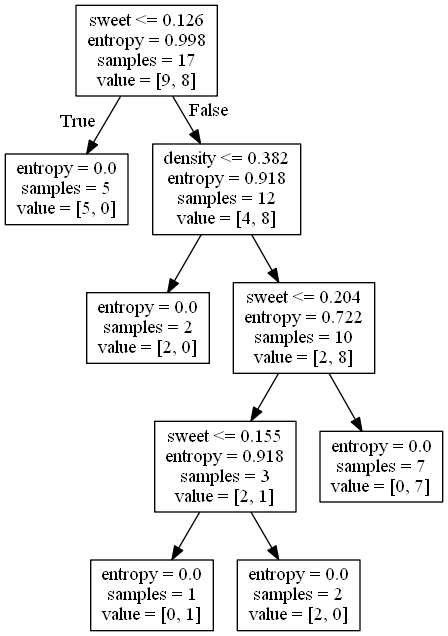

In [28]:
dot_data = StringIO()
tree.export_graphviz(model, out_file=dot_data, feature_names = X.columns, )
graph = pydotplus.pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png("water_melon_data_3.png")
Image(filename='water_melon_data_3.png')

### 가지치기 미수행, 사전 가지치기, 사후 가지치기 비교

일반화 성능 향상 판단 방법 : 홀드아웃 세트
훈련 데이터 : {1,2,3,6,7,10,14,15,16,17}
/ 검정 세트 : {4,5,8,9,11,12,13}
    
    

#### 가지치기 미수행

In [29]:
from sklearn import tree

In [30]:
train_set = water_melon_data_3.iloc[[0,1,2,5,6,9,13,14,15,16]]
test_set = water_melon_data_3.iloc[[3,4,7,8,10,11,12]]

In [31]:
X_train = train_set[['density', 'sweet']]
y_train = train_set[['ripe']]

X_test = train_set[['density', 'sweet']]
y_test = train_set[['ripe']]

In [32]:
model = tree.DecisionTreeClassifier(criterion = 'entropy', random_state=0)
model = model.fit(X_train, y_train)

In [33]:
print("훈련 세트 정확도: {:.3f}".format(model.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(model.score(X_test, y_test)))

훈련 세트 정확도: 1.000
테스트 세트 정확도: 1.000


#### 사전 가지치기

정지 규칙으로 트리의 깊이, 마지막 노드의 최소 데이터 수, 불순척도 등의 임계치를 이용하기도 함

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

pre_prune_tree = DecisionTreeClassifier(criterion = 'entropy',max_depth=3, random_state=0)
pre_prune_tree.fit(X_train, y_train)

print("훈련 세트 정확도: {:.3f}".format(pre_prune_tree.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(pre_prune_tree.score(X_test, y_test)))

훈련 세트 정확도: 0.900
테스트 세트 정확도: 0.900


#### 사후 가지치기

노드에서 가장 낮은 값이 1 미만일 때 트리 성장을 멈추는 방법

In [35]:
from sklearn.tree._tree import TREE_LEAF # -1

def postPruning(inner_tree, index, threshold):
    if inner_tree.value[index].min() < threshold:
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF

    if inner_tree.children_left[index] != TREE_LEAF:
        postPruning(inner_tree, inner_tree.children_left[index], threshold)
        postPruning(inner_tree, inner_tree.children_right[index], threshold)

In [36]:
post_prune_tree = DecisionTreeClassifier(criterion = 'entropy', random_state=0)
post_prune_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [37]:
print("훈련 세트 정확도: {:.3f}".format(post_prune_tree.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(post_prune_tree.score(X_test, y_test)))

훈련 세트 정확도: 1.000
테스트 세트 정확도: 1.000


#### splitter = 'random' 설정

In [38]:
model2 = tree.DecisionTreeClassifier(criterion = 'entropy',splitter='random', random_state=0)
# model2 = model2.fit(X, Y)
model2 = model2.fit(X_train, y_train)

In [39]:
print("훈련 세트 정확도: {:.3f}".format(model2.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(model2.score(X_test, y_test)))

훈련 세트 정확도: 1.000
테스트 세트 정확도: 1.000


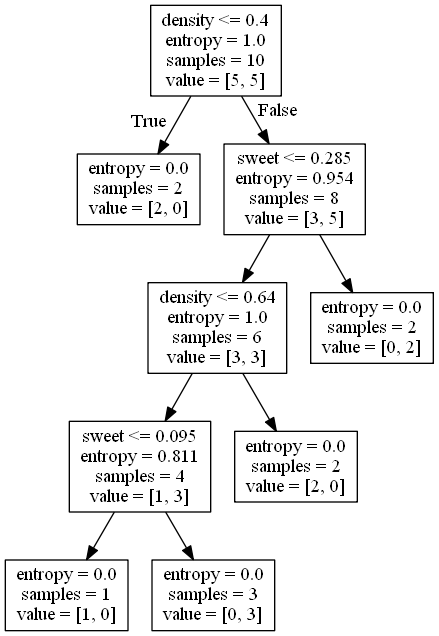

In [40]:
dot_data = StringIO()
tree.export_graphviz(model2, out_file=dot_data, feature_names = X.columns)
graph = pydotplus.pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png("water_melon_data_3.png")
Image(filename='water_melon_data_3.png')

#### criterion = 'gini' 설정

In [41]:
model3 = tree.DecisionTreeClassifier(criterion = 'gini',splitter='best', random_state=0)
# model3 = model3.fit(X, Y)
model3 = model3.fit(X_train, y_train)

In [42]:
print("훈련 세트 정확도: {:.3f}".format(model3.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(model3.score(X_test, y_test)))

훈련 세트 정확도: 1.000
테스트 세트 정확도: 1.000


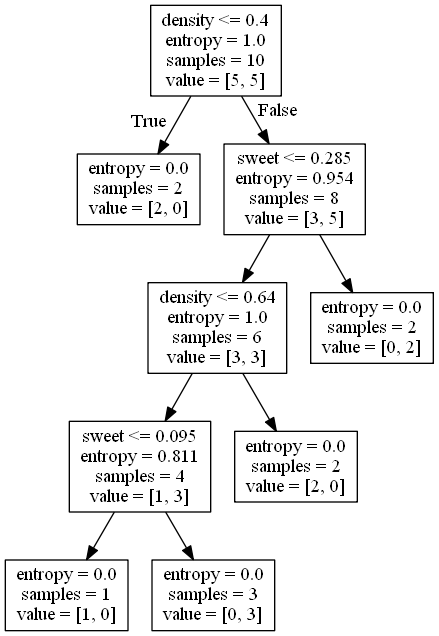

In [43]:
dot_data = StringIO()
tree.export_graphviz(model2, out_file=dot_data, feature_names = X.columns)
graph = pydotplus.pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png("water_melon_data_3.png")
Image(filename='water_melon_data_3.png')